In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from data_process import tokenizers, utils
from nanoGPT.model import  GPT, GPTConfig
from lightning_training import LightningGPT, GamesDataModule, GamesDataset
import pytorch_lightning as pl
import torch
import os
import numpy as np
import seaborn as sns

In [ ]:
headers = ["index", "id", "date", "white_elo", "black_elo", "result", "ply", "ply_30s", "piece_uci"]

games_df = pd.read_csv("./data/test.csv", delimiter=";", header=None, names=headers)

games_df['piece_uci'] = utils.remove_material_tokens(games_df['piece_uci'])

games_df = games_df.sample(frac=0.1, random_state=42)

games_df

,index,id,date,white_elo,black_elo,result,ply,ply_30s,piece_uci
75721,99034768,j8dut9JL,2025.01.31,2425,2427,1-0,85,68,Pd2d4 Ng8f6 Ng1f3 Pc7c5 Pe2e3 Pb7b6 Bf1d3 Bc8b...
80184,7380677,UMIvcBzB,2024.12.03,1919,2020,1-0,67,47,Pd2d4 Ng8f6 Nb1c3 Pc7c5 Pd4d5 Pd7d6 Pe2e4 Pg7g...
19864,14462158,RP3reGqr,2024.12.05,2135,2144,1-0,41,-1,Ng1f3 Pc7c6 Pg2g3 Pd7d5 Pd2d3 Pe7e6 Bf1g2 Bf8d...
76699,99355390,OC9pukWM,2025.01.31,2402,2433,1-0,53,-1,Pc2c4 Pe7e6 Nb1c3 Pd7d5 Pd2d4 Pc7c5 Pc4d5 Pe6d...
92991,14089339,BL4die9s,2024.12.05,1200,1143,1-0,45,-1,Pe2e4 Pd7d5 Pe4d5 Qd8d5 Nb1c3 Qd5d8 Ng1f3 Pa7a...
...,...,...,...,...,...,...,...,...,...
16783,14423585,b9vqZyEs,2024.12.05,2211,2071,1-0,143,113,Pd2d4 Ng8f6 Ng1f3 Pd7d5 Bc1f4 Pe7e6 Pe2e3 Bf8d...
41130,6322263,x8pAAmBC,2024.12.03,1466,1821,0-1,24,-1,Pe2e4 Pc7c5 Ng1f3 Pe7e6 Pc2c4 Pd7d5 Pe4d5 Pe6d...
78318,99740146,nx1hgLAd,2025.01.31,2577,2555,1-0,61,-1,Ng1f3 Ng8f6 Pg2g3 Pb7b6 Bf1g2 Bc8b7 Ke1g1 Pc7c...
72169,98073269,6E54p2aw,2025.01.31,2500,2500,1-0,65,55,Pe2e4 Pg7g6 Pd2d4 Bf8g7 Nb1c3 Pd7d6 Bc1e3 Pc7c...


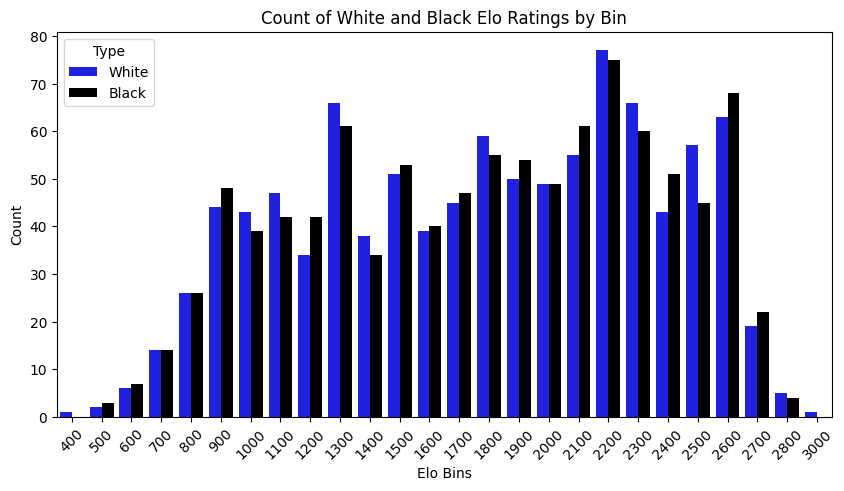

In [3]:
white_elo_bins = games_df.white_elo // 100 * 100
black_elo_bins = games_df.black_elo // 100 * 100

data = pd.DataFrame({
    'Elo Bin': list(white_elo_bins) + list(black_elo_bins),
    'Type': ['White'] * len(white_elo_bins) + ['Black'] * len(black_elo_bins)
})

plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='Elo Bin', hue='Type', palette=['blue', 'black'])
plt.xticks(rotation=45)
plt.xlabel("Elo Bins")
plt.ylabel("Count")
plt.title("Count of White and Black Elo Ratings by Bin")
plt.show()

In [22]:
tokenizer = tokenizers.FullMoveTokenizerWithElo()

model_config = GPTConfig(
    block_size=302,
    vocab_size=tokenizer.vocab_size,
    n_layer=8,
    n_head=8,
    n_embd=512,
    bias=False,
)

test_start_token = 11

masked_elo_checkpoint = "./models/full_training/masked_elo/epoch=9-step=1250000.ckpt"
elo_checkpoint = "./models/full_training/adaptive_elo/epoch=9-step=1250000.ckpt"

masked_elo_model = LightningGPT.load_from_checkpoint(masked_elo_checkpoint, config=model_config, test_start_token=test_start_token)
elo_model = LightningGPT.load_from_checkpoint(elo_checkpoint, config=model_config, test_start_token=test_start_token)

number of parameters: 27.29M
number of parameters: 27.29M


In [23]:
trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=10,
    callbacks=[pl.callbacks.RichProgressBar()],
    precision="bf16-mixed",
)
torch.set_float32_matmul_precision('high')

Using bfloat16 Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [17]:
cuts = games_df.ply_30s
games_with_elo = utils.add_elo_token_to_games(games_df.piece_uci, games_df.white_elo, games_df.black_elo)
games_with_elo

75721    2400 2400 Pd2d4 Ng8f6 Ng1f3 Pc7c5 Pe2e3 Pb7b6 ...
80184    1900 2000 Pd2d4 Ng8f6 Nb1c3 Pc7c5 Pd4d5 Pd7d6 ...
19864    2100 2100 Ng1f3 Pc7c6 Pg2g3 Pd7d5 Pd2d3 Pe7e6 ...
76699    2400 2400 Pc2c4 Pe7e6 Nb1c3 Pd7d5 Pd2d4 Pc7c5 ...
92991    1200 1100 Pe2e4 Pd7d5 Pe4d5 Qd8d5 Nb1c3 Qd5d8 ...
                               ...                        
5002     2700 2500 Pd2d4 Pd7d5 Nb1c3 Ng8f6 Bc1f4 Pc7c5 ...
30151    2200 2100 Pc2c4 Pe7e6 Ng1f3 Pd7d5 Pg2g3 Ng8f6 ...
93194    1000 1100 Pe2e4 Pe7e5 Pd2d3 Nb8c6 Nb1c3 Ng8f6 ...
73199    2400 2400 Pe2e4 Pd7d5 Pe4d5 Qd8d5 Nb1c3 Qd5d6 ...
74479    2500 2500 Pd2d4 Ng8f6 Nb1c3 Pg7g6 Ng1f3 Pd7d5 ...
Length: 10000, dtype: object

In [18]:
elo_data_module = GamesDataModule(test_games=list(games_with_elo), tokenizer=tokenizer, num_workers=12, mask_elo_token=True)

In [19]:
trainer.test(masked_elo_model, datamodule=elo_data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5150818824768066     │
│         test_loss         │     1.504554271697998     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.504554271697998, 'test_acc': 0.5150818824768066}]

In [ ]:
trainer.test(masked_elo_model, datamodule=elo_data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5107116103172302     │
│         test_loss         │    1.7678557634353638     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.7678557634353638, 'test_acc': 0.5107116103172302}]

In [ ]:
masked_elo_model = LightningGPT.load_from_checkpoint(masked_elo_checkpoint, config=model_config, test_start_token=11)

number of parameters: 27.29M


In [ ]:
trainer.test(masked_elo_model, datamodule=elo_data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5110811591148376     │
│         test_loss         │    1.7678557634353638     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.7678557634353638, 'test_acc': 0.5110811591148376}]

In [11]:
trainer.test(elo_model, datamodule=elo_data_module)

2025-03-22 12:56:09.778917: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742644569.853965   16263 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742644569.874195   16263 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-22 12:56:10.062748: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5142906904220581     │
│         test_loss         │     1.623957633972168     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.623957633972168, 'test_acc': 0.5142906904220581}]

In [13]:
elo_model = LightningGPT.load_from_checkpoint(elo_checkpoint, config=model_config, test_start_token=11)

trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=10,
    callbacks=[pl.callbacks.RichProgressBar()],
    precision="bf16-mixed",
)
torch.set_float32_matmul_precision('high')

Using bfloat16 Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


number of parameters: 27.29M


In [14]:
trainer.test(elo_model, datamodule=elo_data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.512260377407074     │
│         test_loss         │     1.623957633972168     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.623957633972168, 'test_acc': 0.512260377407074}]